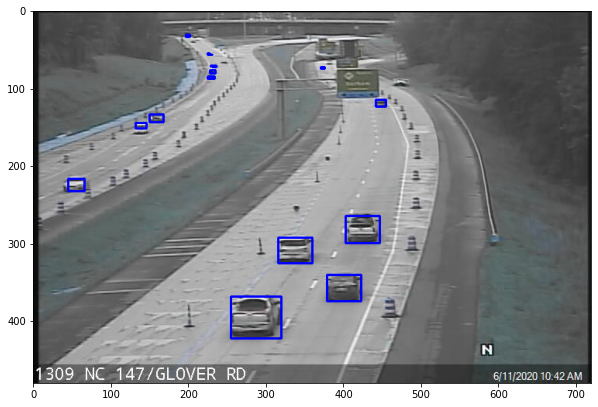

In [2]:
from shapely.geometry import mapping, Polygon
from shapely.geometry import box as bx
from shapely.ops import unary_union
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
#
## Import image, Use cv to get background, contours & bounding Hull polygon
#
frames0 = [cv.imread('HW147images/2020-6-11-10-42.png'),
           cv.imread('HW147images/2020-6-11-10-47.png') ]
frames1 = [cv.imread('HW147images/2020-6-11-10-38.png'),
           cv.imread('HW147images/2020-6-11-10-42.png'),]
fgbg0 = cv.bgsegm.createBackgroundSubtractorMOG(history=1)
fgbg1 = cv.bgsegm.createBackgroundSubtractorMOG(history=1)

for frame in frames0:
    fgmask0 = fgbg0.apply(frame)
    not_same0=fgmask0

for frame in frames1:
    fgmask1 = fgbg1.apply(frame)
    not_same1=fgmask1

img = cv.bitwise_and(not_same1, not_same0)
im= img[:465, :]                            # crop time out of image

ret,thresh = cv.threshold(im,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
s = [cv.convexHull(cont) for cont in contours]

#
## Useful tests: Close, disjoint, merge (polygons) :- recursion of these
#

def epsilom(y_val):
    #finds value of CAR_LENGTH corresponding to y-val
    CAR_LENGTH=3.4896*np.exp(0.0069*y_val) #car length 
    return CAR_LENGTH
#
def stackoverflow_dude(cluster_list):
    """
    Blatant theft! The enclosed functions - graph DFS implementation.
    https://stackoverflow.com/a/4843380
    Take in cluster list (list of lists), and returns merged clusters
    """    
    taken=[False]*len(cluster_list)
    cluster_list=[set(elem) for elem in cluster_list]
    
    def dfs(node,index):
        taken[index]=True
        ret=node
        for i,item in enumerate(cluster_list):
            if not taken[i] and not ret.isdisjoint(item):
                ret.update(dfs(item,i))
        return ret

    def merge_all():
        ret=[]   #previous: []
        for i,node in enumerate(cluster_list):
            if not taken[i]:
                ret.append(list(dfs(node,i))) #previous append
        return ret
    return merge_all()
#
def Polys_not_disjoint(d):
    #Input: d=>List of Polygon objects; Output: List of polygons that aren't overlapping or "close".
    overlap_list=[]
    if len(d)<2:
        return d
    for i in range(len(d)):
        for j in range(i+1,len(d)):
            if (not d[i].disjoint(d[j])) or  (       #if overlapping
                    d[i].exterior.distance(d[j])<0.35*epsilom((min(d[i].centroid.y,d[j].centroid.y))) ): # or if close 
              
                overlap_list.append([i,j]) 
    if not overlap_list:
        return d

    fixed_list=stackoverflow_dude(overlap_list)
    #
    ## We now have all the overlapping or close objects in list so ready to merge & pop
    for cluster in fixed_list:
        polygons=[d[i] for i in cluster]
        x1,y1,x2,y2=list(map(int,unary_union(polygons).bounds))
        new_box=Polygon(bx(x1,y1,x2,y2).exterior.coords)
        d.append(new_box)
    ##
    remove_indices=[x for cluster in fixed_list for x in cluster]

    new_d=[d[i] for i in range(len(d)) if i not in remove_indices]
    return new_d
    
def no_intersect(d):
    # base case: no overlapping. Recursion happens in other function. This function is just to check!!
    # Input: List of Polygon objects
    flag=False                       #flag of whether there were overlapping rectangles or not.
    if len(d)<2:
        return flag,d           # job of calling function to check that we not recursively entering same cluster
    new_poly_list=Polys_not_disjoint(d)
    
    if len(new_poly_list) != len(d):
        flag=True
                                    
    return flag,new_poly_list
                                            
def call_no_intersect(cluster_list):
    flag=True
    while flag:
        flag,cluster_list=no_intersect(cluster_list)
    return cluster_list
##
#
s_objcts=[x.tolist() for x in s]

d=[]
for x in s_objcts:
    poly=[]
    for item in x:
        poly.append(item[0])
    #A LinearRing must have at least 3 coordinate tuples
    if len(poly)<3:
        x,y,w,h = cv.boundingRect(np.int0(poly))
        box=[[x,y],[x+w,y],[x,y+h],[x+w,y+h]]
        poly=box  
    d.append(Polygon(poly))
#
##At this point we have a list -d of Polygon objects
#
# Check for intersect and merge (by calling trio of connected functions above)
d=call_no_intersect(d)

#Final filter for bounding rectangles that are too small to be a real car, or part thereof.
d2=[d[i] for i in range(len(d)) if d[i].area>0.25*(epsilom(d[i].centroid.y)**2)] # area greater than 1/4 car

#Turn polygons into contour objects so can be drawn on image
v=[mapping(d2[j])['coordinates'][0] for j in range(len(d2))] 
v1=[]
for poly in v:
    v1.append([list(map(int,(x))) for x in poly])

v2=[np.array(x) for x in v1] # apparently this is the form of a contour

#draw to frame
cv.drawContours(frames0[0],v2,-1,(0,0,255),2)
plt.figure(figsize=(10,20))
plt.imshow(frames0[0])
#
#
                        

